# Behavioral Cloning-Project

## Driving data set

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import sklearn
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, Cropping2D, Lambda, Dense, Flatten
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import Model

from src import get_driving_data, \
    parse_data_row, \
    steering_image_batch_generator

Using TensorFlow backend.


### Load data

In [2]:
data_dir = os.path.join('/home', 'Simulation_Data')
log_csv = os.path.join(data_dir, 'driving_log.csv')

driving_df = get_driving_data(log_csv)
print(driving_df.loc[5])  # print random example to check that data is as expected

Center image    IMG/center_2018_10_20_21_50_37_206.jpg
Left image        IMG/left_2018_10_20_21_50_37_206.jpg
Right image      IMG/right_2018_10_20_21_50_37_206.jpg
Steering                                     -0.122066
Name: 5, dtype: object


### Exploring data

In [3]:
n_samples = driving_df.shape[0]
steering_df = driving_df['Steering']
mean_steering = steering_df.mean()
min_steering = steering_df.min()
max_steering = steering_df.max()
print(f'number of steering angles recorded: {n_samples} x 3 = {n_samples*3}'
      f'\nmin steering angle: {min_steering}'
      f'\nmax steering angle: {max_steering}'
      f'\nmean steering angle: {mean_steering}')

number of steering angles recorded: 9742 x 3 = 29226
min steering angle: -1.0
max steering angle: 1.0
mean steering angle: -0.0011161202688359676


Data shows that steering angles in the driving log are already normalized to be in range between -1 and 1. For demonstration purpose I also want to look at the real angles which means that angles have to be scaled back.
The normalization code can be found here: [GitHub udacity/self-driving-car-sim](https://github.com/udacity/self-driving-car-sim/blob/bdcd588990df2db4706e772cd45d6e013631a2f2/Assets/Standard%20Assets/Vehicles/Car/Scripts/CarController.cs#L472). So, all angles are divided by the maximum steering angle before logging which equals 25° in the present version of the simulator.


min steering angle: -25.0
max steering angle: 25.0
mean steering angle: -0.02790300672089913


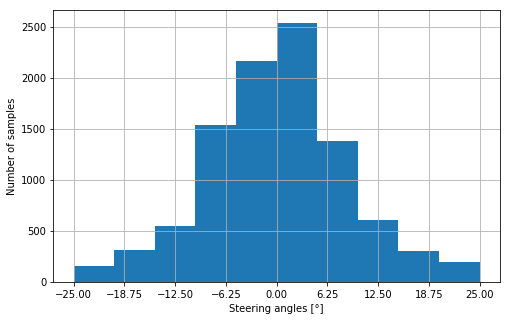

In [4]:
real_angles_df = steering_df*25.0
mean_steering = real_angles_df.mean()
min_steering = real_angles_df.min()
max_steering = real_angles_df.max()
print(f'\nmin steering angle: {min_steering}'
      f'\nmax steering angle: {max_steering}'
      f'\nmean steering angle: {mean_steering}')
angles_hist = real_angles_df.hist(figsize=(8, 5))
angles_hist.set_xlabel('Steering angles [°]')
angles_hist.set_ylabel('Number of samples')
angles_hist.set_xticks(np.linspace(min_steering, max_steering, 9))
plt.show()

0       -2.816902
1       -2.816902
2       -2.816902
3       -2.816902
4       -2.816902
5       -3.051642
6       -3.051642
7       -3.403755
8       -3.873240
9       -4.225352
10      -4.225352
11      -4.225352
12      -4.225352
13      -4.225352
14       0.000000
15       0.000000
16       0.000000
17       0.000000
18       0.000000
19       0.000000
20       0.000000
21       0.000000
22      -0.938967
23      -1.173709
24      -1.525822
25      -1.525822
26      -1.525822
27      -1.643192
28      -1.995305
29      -2.464789
          ...    
9712    16.314555
9713    16.314555
9714    13.967135
9715     5.281690
9716     2.816902
9717    -1.525822
9718    -7.629107
9719    -7.629107
9720    -7.629107
9721    -7.629107
9722    -6.103288
9723     5.164320
9724     5.985915
9725     7.394365
9726     7.863850
9727     8.215962
9728     8.802817
9729     8.920188
9730     8.920188
9731     8.920188
9732     8.920188
9733     8.920188
9734     8.920188
9735     8.920188
9736     8

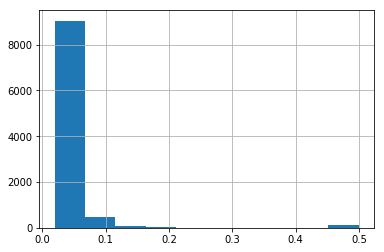

In [5]:
nvidia_df = 1/(real_angles_df+27.0)
nvidia_df.hist()
print(real_angles_df)

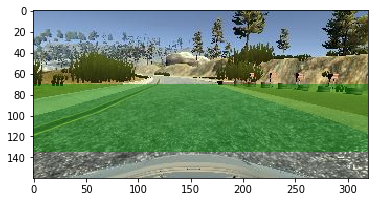

In [6]:
# Plot sample image
sample_image_name = driving_df.loc[152]['Center image']  # randomly chosen index
sample_image_file = os.path.join(data_dir, sample_image_name)
sample_image = cv2.imread(sample_image_file)

plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))

# Determine region of interest for cropping
original_image_height = sample_image.shape[0]
original_image_width = sample_image.shape[1]

# do not touch width
left = 0
right = original_image_width
# only crop height
bottom_crop = 25
top_crop = 70

bottom = original_image_height - bottom_crop
top = top_crop

rect = np.array([
    [left, top],
    [right, top],
    [right, bottom],
    [left, bottom]
])
rect_x = rect[:,0]-.5  # substract small amount to prevent plot from expanding into whitespace
rect_y = rect[:,1]

# Plot region of interest on top of sample image
plt.fill(rect_x, rect_y, facecolor='green', alpha=.5)

### Create train and validation sets from driving data

In [7]:
# Create training and validation dataset
train_set, validation_set = train_test_split(driving_df.values, test_size=0.2)

train_generator = steering_image_batch_generator(data_dir, train_set)
validation_generator = steering_image_batch_generator(data_dir, validation_set)

# Also create a smaller training and validation dataset for testing models
small_train_set, small_validation_set = train_test_split(driving_df[:1000].values, test_size=0.3)

images, steering = [], []
for row in small_train_set:
    i, s = parse_data_row(data_dir, row)
    images.append(i)
    steering.append(s)
x_train, y_train = np.array(images), np.array(steering)

images, steering = [], []
for row in small_validation_set:
    i, s = parse_data_row(data_dir, row)
    images.append(i)
    steering.append(s)
x_validation, y_validation = np.array(images), np.array(steering)

In [8]:
print(train_set[0:5])

[['IMG/center_2018_10_20_21_51_53_141.jpg'
  'IMG/left_2018_10_20_21_51_53_141.jpg'
  'IMG/right_2018_10_20_21_51_53_141.jpg' 0.07511737]
 ['IMG/center_2018_10_20_21_51_20_046.jpg'
  'IMG/left_2018_10_20_21_51_20_046.jpg'
  'IMG/right_2018_10_20_21_51_20_046.jpg' -0.1220657]
 ['IMG/center_2018_10_20_22_42_39_505.jpg'
  'IMG/left_2018_10_20_22_42_39_505.jpg'
  'IMG/right_2018_10_20_22_42_39_505.jpg' -0.4976526]
 ['IMG/center_2018_10_20_22_19_59_856.jpg'
  'IMG/left_2018_10_20_22_19_59_856.jpg'
  'IMG/right_2018_10_20_22_19_59_856.jpg' 0.2300469]
 ['IMG/center_2018_10_20_22_18_01_603.jpg'
  'IMG/left_2018_10_20_22_18_01_603.jpg'
  'IMG/right_2018_10_20_22_18_01_603.jpg' 0.4225352]]


## PilotNet model

In [9]:
img_height = original_image_height
img_width = original_image_width

input_layer = Input(shape=(img_height, img_width, 3), name='input_image')

# Crop the input image first,
# then normalize it.
x = Cropping2D(cropping=((top_crop, bottom_crop), (0, 0)), name='image_cropping')(input_layer)
x = Lambda(lambda n: n / 255.0 - 0.5, name='image_normalization')(x)

x = Conv2D(24, (5, 5), strides=(2, 2), activation='relu', name='conv1')(x)
x = Conv2D(36, (5, 5), strides=(2, 2), activation='relu', name='conv2')(x)
x = Conv2D(48, (5, 5), strides=(2, 2), activation='relu', name='conv3')(x)
x = Conv2D(64, (3, 3), activation='relu', name='conv4')(x)
x = Conv2D(64, (3, 3), activation='relu', name='conv5')(x)
x = Flatten(name='flatten')(x)
x = Dense(100, name='dense1')(x)
x = Dense(50, name='dense2')(x)
x = Dense(10, name='dense3')(x)
x = Dense(1, name='output_angle')(x)

model = Model(input=input_layer, output=x)
model.compile(loss='mse', optimizer='Nadam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     (None, 160, 320, 3)       0         
_________________________________________________________________
image_cropping (Cropping2D)  (None, 65, 320, 3)        0         
_________________________________________________________________
image_normalization (Lambda) (None, 65, 320, 3)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 31, 158, 24)       1824      
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 77, 36)        21636     
_________________________________________________________________
conv3 (Conv2D)               (None, 5, 37, 48)         43248     
_________________________________________________________________
conv4 (Conv2D)               (None, 3, 35, 64)         27712     
__________

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


In [10]:
import time

def get_log_dir(base_path='./logs/PilotNet', path_suffix=None):
    localtime = time.localtime()
    datetime_string = time.strftime("%Y-%m-%d_%H-%M-%S", localtime)
    if path_suffix is not None:
        return f'{base_path}/{path_suffix}/{datetime_string}'
    return f'{base_path}/{datetime_string}'

In [11]:
tensorboard = TensorBoard(log_dir=get_log_dir(path_suffix='/debug'),
                          batch_size=32,
                          write_images=True,
                          write_graph=True,
                          write_grads=True,
                          histogram_freq=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')

model.fit(x_train, y_train,
          validation_data=(x_validation, y_validation),
          batch_size=32,
          epochs=8,
          callbacks=[tensorboard, early])

Train on 700 samples, validate on 300 samples
Epoch 1/8
700/700 [==============================] - 4s 5ms/step - loss: 0.1023 - val_loss: 0.0029
Epoch 2/8
700/700 [==============================] - 1s 1ms/step - loss: 0.0032 - val_loss: 0.0040
Epoch 3/8
700/700 [==============================] - 1s 1ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 4/8
700/700 [==============================] - 1s 1ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 5/8
700/700 [==============================] - 1s 1ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 6/8
700/700 [==============================] - 1s 1ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 7/8
700/700 [==============================] - 1s 1ms/step - loss: 6.5216e-04 - val_loss: 0.0012
Epoch 8/8
700/700 [==============================] - 1s 1ms/step - loss: 4.5400e-04 - val_loss: 8.0883e-04


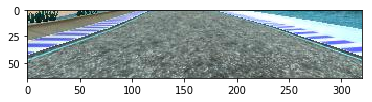

In [25]:
layer_name = 'image_cropping'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(x_train[None, 40])
plt.imshow(intermediate_output[0].astype(np.uint8))

In [16]:
layer_name = 'output_angle'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(x_train[0:500])
print(intermediate_output)

[[ 0.00268667]
 [ 0.04671298]
 [-0.01849305]
 [ 0.05526184]
 [ 0.00092757]
 [ 0.06893851]
 [-0.00521392]
 [-0.02765371]
 [ 0.03979154]
 [-0.03681777]
 [-0.08633304]
 [-0.04285734]
 [-0.02657627]
 [-0.04423196]
 [-0.08859476]
 [ 0.06517321]
 [-0.01015445]
 [ 0.02729275]
 [ 0.0485175 ]
 [-0.0188386 ]
 [ 0.03690479]
 [ 0.0860885 ]
 [ 0.00301734]
 [-0.03090547]
 [-0.11210345]
 [-0.0297387 ]
 [-0.02364404]
 [-0.00534986]
 [-0.01065985]
 [-0.00334964]
 [ 0.03519331]
 [-0.0074523 ]
 [ 0.08819805]
 [-0.00672017]
 [-0.06516489]
 [ 0.00449528]
 [-0.00303077]
 [-0.14909418]
 [-0.09693567]
 [-0.07233793]
 [ 0.04408612]
 [ 0.04366276]
 [-0.04846277]
 [-0.0018026 ]
 [-0.00466758]
 [-0.12656072]
 [-0.04987836]
 [-0.06383657]
 [ 0.02830523]
 [ 0.04129893]
 [-0.01117016]
 [-0.03933063]
 [-0.06415156]
 [ 0.07057916]
 [ 0.01225522]
 [-0.00679878]
 [ 0.01467819]
 [-0.00761698]
 [ 0.03192004]
 [-0.04644952]
 [-0.04767347]
 [ 0.04353542]
 [-0.01075468]
 [-0.10024994]
 [-0.04016523]
 [ 0.04864482]
 [ 0.12999

In [15]:
tensorboard = TensorBoard(log_dir=get_log_dir(),
                                  batch_size=32,
                                  write_graph=False)
# Save the model according to the conditions
checkpoint = ModelCheckpoint('PilotNet.h5', monitor='val_loss', verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')

model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=3,
                    steps_per_epoch=len(train_set),
                    validation_steps=len(validation_set),
                    callbacks=[tensorboard, checkpoint, early])

Epoch 1/3
7793/7793 [==============================] - 293s 38ms/step - loss: 0.0000e+00 - val_loss: 0.0084

Epoch 00001: val_loss improved from inf to 0.00843, saving model to PilotNet.h5
Epoch 2/3
7793/7793 [==============================] - 304s 39ms/step - loss: 0.0000e+00 - val_loss: 0.0084

Epoch 00002: val_loss did not improve from 0.00843
Epoch 3/3
7793/7793 [==============================] - 301s 39ms/step - loss: 0.0000e+00 - val_loss: 0.0084

Epoch 00003: val_loss did not improve from 0.00843
Epoch 00003: early stopping


## Xception - transfer learning model

In [ ]:
"""from keras.applications import Xception
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

img_width = 150
img_height = 150

model = Xception(weights='imagenet',
                 include_top=False,
                 input_shape=(img_height, img_width, 3))

# Freeze all layers of pre-trained model
for layer in model.layers:
    layer.trainable = False

x = model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1)(x)  # Regression output layer

model_final = Model(input=model.input, output=x)
model_final.compile(loss='mse', optimizer='Nadam')

# Save the model according to the conditions  
checkpoint = ModelCheckpoint('Xception_steering.h5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

model_final.fit_generator(train_generator, 
                          samples_per_epoch=len(train_samples), 
                          validation_data=validation_generator,
                          nb_val_samples=len(validation_samples), 
                          nb_epoch=10, 
                          callbacks=[checkpoint, early])"""